# SpaceNet U-Net

This notebook is orginal from Boggis30 named 'SpaceNetUnet'. URL: https://github.com/boggis30/SpaceNetUnet
I added some comments to better understand the code 

### Summary of  the Notebook: 
This code executes building detection with the help of an U-Net-like architecture. 
By additionally reducing the final layer, the models' accuracy increases (improved model). 

Model: 
- Conv2D; (Batch Normalization); ReLu; double convolution possible
- Maxpooling 

- UNetUp: Conv2DTranspose + Concatenate

- final_reduce = False: Conv2D
- final_reduce = True: Conv2D, Lambda(reduce_layer)

Lastly, explore the filters with Hyperopt ---> best results?!

Thought and ideas on improving the code or comparing with other applications: 



# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import tensorboard

import glob
import os

import re
import datetime

from PIL import Image


import numpy as np
import pandas as pd

from sklearn.metrics import multilabel_confusion_matrix


from hyperopt import hp
from hyperopt import fmin, pyll, tpe, hp, STATUS_OK, Trials

import pickle
import time

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

#import pydot
#import graphviz

In [2]:
# check for the gpu

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4383664978011703284,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9894756352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1975703051535918879
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2d:00.0, compute capability: 8.6"]

# Data Generators

Generate Data to feed the UNet with !

In [4]:
# add here the folder path, where your SpaceNet data is stored
directory = 'F:/DL_building_detection/InnovationLab/tiles'


files = glob.glob(os.path.join(directory,'*'))

pattern_img = '.*\.jpg'
# create a list of all images in that directory [after converting them to jpg with the code in Github README]
files_img = list(filter(re.compile(pattern_img).match,files))

pattern_mask = '.*\.tif'
# create a list of all labeled/classified images [therefore masks]
files_mask = list(filter(re.compile(pattern_mask).match,files))

files_mask = sorted(files_mask)
files_img = sorted(files_img)

print(' All files: {}\n'.format(len(files)),
      'Image files: {}\n'.format(len(files_img)),
      'Mask files: {}'.format(len(files_mask)))

 All files: 7702
 Image files: 3851
 Mask files: 3851


In [5]:
# create a dataframe of the satellite images and their respective mask 
df_files = pd.DataFrame(columns=['img','mask'])
df_files['img'] = files_img
df_files['mask'] = files_mask

# return a random sample [frac defines how big of a fraction of the original data the sampled data should be; 1 means equal]
df_files = df_files.sample(frac=1,random_state=10)


train_bound = int(len(df_files) * 0.7)
val_bound = int(len(df_files) * 0.85)

# define 70% of the data as trainings data and 15% for validation and 15% for testing
df_train = df_files.iloc[:train_bound]
df_val = df_files.iloc[train_bound:val_bound]
df_test = df_files.iloc[val_bound:]

print(' Train examples: {}\n'.format(len(df_train)),
      'Validation examples: {}\n'.format(len(df_val)),
      'Test examples: {}\n'.format(len(df_test)))

 Train examples: 2695
 Validation examples: 578
 Test examples: 578




Image and respective mask examples

Found 10 validated image filenames.
Found 10 validated image filenames.


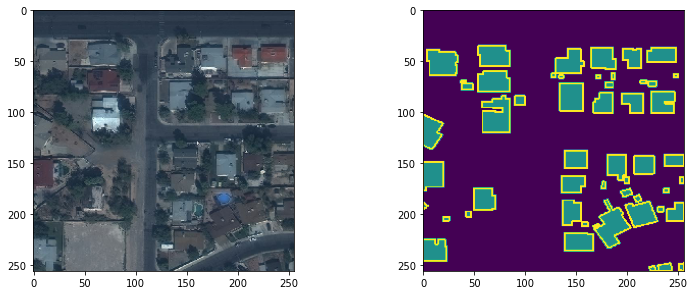

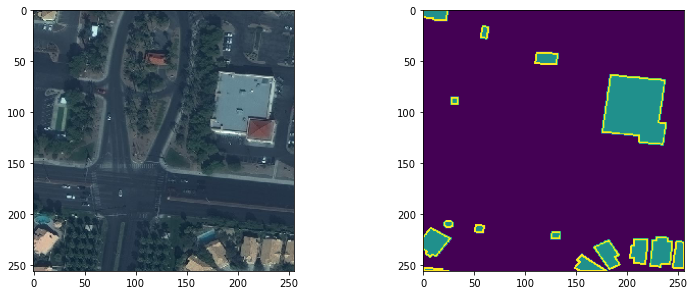

In [6]:
def make_tuple_gen(df_files,target_size,batch_size,seed):# this function generates augmented data[!not only training data!]
    # or better said: it generates a function which generates augmented data[generator function]
    
    # https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    # generate batches of tensor image data with real-time data augmentation 
    # batches of original training data are randomly transformed and then used for training (not the original data!)
  img_gen = keras.preprocessing.image.ImageDataGenerator()
    
    # read data from dataframe and perform powerful on-the-fly image augmentation with ImageDataGenerator
  img_generator = img_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb')
  
  mask_gen = keras.preprocessing.image.ImageDataGenerator()

  mask_generator = mask_gen.flow_from_dataframe(
          dataframe=df_files,        
          x_col='mask',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='grayscale')


  return zip(img_generator, mask_generator)

def make_gen4unet(df_files,target_size = (256, 256),batch_size = 1, seed = 10):
  
  tuple_gen =  make_tuple_gen(df_files,target_size,batch_size,seed) # tuple_gen consists of two generators

  def _gen():  # loop through tuple_gen and for the mask layers: assign values [1,2] to y= [100,255]
    while True: 
      x,y = next(tuple_gen) # returns the next item in a generator, x = img_generator, y = mask_generator
      
      y[y==100] = 1
      y[y==255] = 2

      yield x,y

  return _gen()

print('\nImage and respective mask examples\n')
# This is only an example for display
genUnet = make_gen4unet(df_files.head(10)) # make generators only for 11 files to display
for i in range(2): #idk why they do that, maybe if looking at genUnet
  xx,yy = next(genUnet)
  xx = xx[0].astype(int)
  yy = np.squeeze(yy[0].astype(int)) #reduce by one axis


  plt.figure(figsize=1*np.array([2*6.4, 4.8]))
  plt.subplot(121)
  plt.imshow(xx)
  plt.subplot(122)
  plt.imshow(yy)
  plt.show()

# DEFINE HERE YOUR BATCH SIZE!

In [7]:
train_gen = make_gen4unet(df_train,batch_size=20)
val_gen   = make_gen4unet(df_val,batch_size=20)
test_gen  = make_gen4unet(df_test,batch_size=578) #why take a bigger batch size here? # 578 is the size of the dataset, means we do only have one batch here

Found 2695 validated image filenames.
Found 2695 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.
Found 578 validated image filenames.


# Model

In [8]:
def reduce_layer(n_classes):
  """The idea of this layer is the following:
  Original Unet has final conv layer with three filters. 
  Each filter has to be able to distinguish target class on the final feature map.
  Each filter has capacity of only 65 parameters, which might be insufficient.
  Improved Unet has increased number of filters per class in final conv layer.
  There are three groups of filters as per each class. Filters corresponding to 
  one classes are summed in the final layer before activation. 
  """
  
  def _reduce_layer(x):

    n_channel = x.shape[-1] #take the number in last dimension/axis, corresponds with number of channels
        
    # n_channel must be divisible by n_classes
    assert n_channel % n_classes == 0 # % gives remainder of division, so if you divide n_channel by n_classes it should be 0
    # assert here means: check this condition and immediately trigger an error if the condition is false

    ch1 = int(n_channel/n_classes)
    ch2 = int(2*n_channel/n_classes)
    
    x1 = x[...,:ch1] #last dimension = n_channels/n_classes
    x2 = x[...,ch1:ch2] # last dimension ch1-ch2
    x3 = x[...,ch2:n_channel] 

    x1 = K.sum(x1,axis=-1) # sum of the values in a tensor, alongside the specified axis (axis = dimension)
    x2 = K.sum(x2,axis=-1) # here axis is e.g. (x,x,X), always the last one
    x3 = K.sum(x3,axis=-1)

    y = K.stack([x1,x2,x3],axis=-1) #Stacks a list of rank R tensors into a rank R+1 tensor

    return y

  return _reduce_layer

def conv_block(n_filter,batch_norm=True):

  def _conv_block(x):
  
    if batch_norm:
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x) # 2d here means data is 2d (which image data is), but I guess filters have 3 x 3 x n_channels
    #Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
      x = keras.layers.BatchNormalization()(x) 
      x = keras.layers.ReLU()(x)
    
    else:  
  
      x = keras.layers.Conv2D(n_filter, (3,3),padding='same')(x)    
      x = keras.layers.ReLU()(x)

    return x

  return _conv_block

def unetConv2(n_filter,double_conv=True,batch_norm=True): #decide if you want to do either singular or double conv
    # going down the U
  
  def _unetConv2(x):
    
    if double_conv:    
    
      x = conv_block(n_filter,batch_norm) (x)
      x = conv_block(n_filter,batch_norm) (x)    
    
    else:    
    
      x = conv_block(n_filter,batch_norm) (x)
    
    return x

  return _unetConv2

def unetUp(n_filter,deconv=True): # going up the U, deconvolution means decoding 

  def _unetUp(input1,input2):

    if deconv:

      input2 = keras.layers.Conv2DTranspose(n_filter,(2,2),(2,2))(input2) # convolutional operation, will also upsample but
    # key difference to UpSampling is that the model should learn what is the best upsampling for the job
          
    else:
      
      input2 = keras.layers.UpSampling2D(size=(2,2))(input2) # Simple upscaling of the image using nearest neighbour or bilinear upsampling. 

    x = keras.layers.Concatenate()([input1,input2])

    return x

  return _unetUp

def unetModel(n_classes = 3,image_shape = (256,256,3) ,feature_scale=1, deconv=True, 
                 in_channels=3, double_conv=True, batch_norm=True, 
                 final_reduce=True,final_reduce_n_channel=30):
  
  """final_reduce_n_channel must be devisible by n_classes"""

  filters = [32, 64, 128, 256, 512]
  filters = [x // feature_scale for x in filters]

  x = keras.layers.Input(image_shape)

  conv1 = unetConv2(filters[0],double_conv,batch_norm) (x)
  maxpool1 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv1)

  conv2 = unetConv2(filters[1],double_conv,batch_norm) (maxpool1)
  maxpool2 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv2)

  conv3 = unetConv2(filters[2],double_conv,batch_norm) (maxpool2)
  maxpool3 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv3)

  conv4 = unetConv2(filters[3],double_conv,batch_norm) (maxpool3)
  maxpool4 = keras.layers.MaxPool2D(pool_size = (2,2)) (conv4)

  center = unetConv2(filters[4],double_conv,batch_norm) (maxpool4)

  up_concat4 = unetUp(filters[3],deconv) (conv4,center)
  up_concat3 = unetUp(filters[2],deconv) (conv3,up_concat4)
  up_concat2 = unetUp(filters[1],deconv) (conv2,up_concat3)
  up_concat1 = unetUp(filters[0],deconv) (conv1,up_concat2)
  

  if final_reduce:

    final = keras.layers.Conv2D(final_reduce_n_channel,(1,1)) (up_concat1) #first convolute to size 1,1
    final = keras.layers.Lambda(reduce_layer(n_classes)) (final) # call the function reduce_layer to be performed on the last layer

  else: # if we do not want to reduce the final layer, we only convolute

    final = keras.layers.Conv2D(n_classes,(1,1)) (up_concat1)

  final_softmax = keras.activations.softmax(final, axis=-1) # converts a vector of values to a probability distribution

  model  = keras.Model(x,final_softmax)  # instantiate (erzeugen) the model

  return model

##  Validation

In [9]:
def validate_image(img,mask,model):

    mask_pred = model.predict(img) # generates output predictions for the input samples.

    i=0
    img = img[i].astype(int)
    mask = np.squeeze(mask[i].astype(int)) # reduce by one axis
    mask_pred = np.squeeze(mask_pred[i]) # reduce again by one axis
    mask_pred_rend = np.argmax(mask_pred,axis=-1) # Returns the indices of the maximum values along an axis.

    plt.figure(figsize=0.8*np.array([4*6.4, 4.8]))
    plt.subplot(141) # = plt.subplot(1,4,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(142)
    plt.imshow(mask)
    plt.subplot(143)
    plt.imshow(mask_pred)
    plt.subplot(144)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

def plot_history(history_dict): # I want two plots with almost the same params, so I make a function

  metrics = ['loss', 'sparse_categorical_accuracy'] # training metrics I want to plot (y-axis - names)
  val_metrics = ['val_los', 'val_sparse_categorical_accuracy'] # validation metrics 


  epochs = range(1, len(history_dict['loss']) + 1)

  plt.figure(figsize=0.8*np.array([6*6.4, 4.8]))
  
  for i,metric in enumerate(metrics): # enumerate: Loop over something and have an automatic counter 
    plt.subplot(141+i)    
    plt.plot(epochs, history_dict[metric], 'bo', label='Training ' + metric) # x-axis, y-axis, blue circle markers, label)
    plt.plot(epochs, history_dict['val_' + metric], 'b', label='Validation' + metric) # same as above but with validation, line
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()


  plt.show()

In [10]:
val_image_gen   = make_gen4unet(df_val,batch_size=1,seed=12) # make generator for validation images

img_val,mask_val = next(val_image_gen)

Found 578 validated image filenames.
Found 578 validated image filenames.


# IMPROVED UNET

## Improved Unet Training

In [11]:
model_improved = unetModel(final_reduce=True, final_reduce_n_channel=30) 
# take the same model, but this time final_reduce = TRUE !
model_improved.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')
# tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', **kwargs), could also add an LearningRateSchedule here

In [12]:
# look at model 
#model_improved.summary()

In [13]:
# plot the model for better overview
#tf.keras.utils.plot_model(model_improved, to_file="model_improved.png", show_shapes=True, show_layer_names=True)

In [14]:
%%time
logdir = 'log_dir/improved/12' # ADAPT every time running the model!!

os.makedirs(logdir,exist_ok=True)


tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                         )
# early stopping to find the "perfect" amount of epoches to avoid over- and underfitting
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                               min_delta=0.001,  #minimum amount of change to count as an improvement)
                                               patience=20, # number of epochs with no improvement after which training will be stopped
                                               restore_best_weights=True
                                              )
                                    

history_model_improved = model_improved.fit(train_gen, 
                              steps_per_epoch=25, 
                              epochs=200,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=[tensorboard, early_stopping])

Epoch 1/200
25/25 [==============================] - 10s 239ms/step - loss: 0.5906 - sparse_categorical_accuracy: 0.7910 - val_loss: 3.4392 - val_sparse_categorical_accuracy: 0.7565
Epoch 2/200
25/25 [==============================] - 6s 230ms/step - loss: 0.3989 - sparse_categorical_accuracy: 0.8535 - val_loss: 2.9040 - val_sparse_categorical_accuracy: 0.1889
Epoch 3/200
25/25 [==============================] - 5s 203ms/step - loss: 0.3908 - sparse_categorical_accuracy: 0.8576 - val_loss: 1.0880 - val_sparse_categorical_accuracy: 0.5682
Epoch 4/200
25/25 [==============================] - 5s 201ms/step - loss: 0.3321 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.7485 - val_sparse_categorical_accuracy: 0.7131
Epoch 5/200
25/25 [==============================] - 5s 200ms/step - loss: 0.3196 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.4406 - val_sparse_categorical_accuracy: 0.8391
Epoch 6/200
25/25 [==============================] - 6s 246ms/step - loss: 0.2901 - sparse_cat

In [15]:
#saving the model for later

model_improved.save("models/12_model_improved")
#model_improved = keras.models.load_model("4_model_improved.h5")
#model_improved.summary()

INFO:tensorflow:Assets written to: models/12_model_improved\assets


## Improved Unet Validation

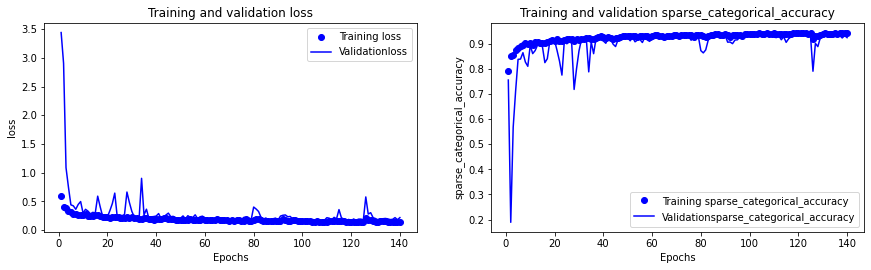

In [16]:
plot_history(history_model_improved.history)

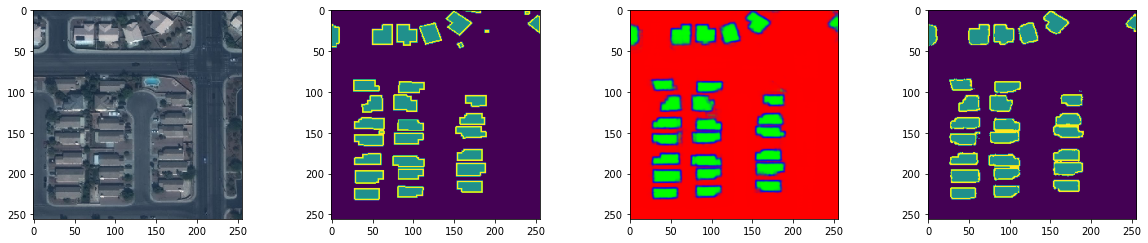

In [17]:
_ = validate_image(img_val,mask_val,model_improved)
# 1: img  2: mask  3: mask_prediction improved_model  4: mask_pred_rend improved_model 

## Improved Unet Analysis

In [ ]:
# launch tensorflow 
%load_ext tensorboard
%tensorboard --logdir 'F:\DL_building_detection\InnovationLab\log_dir\improved\'

In [19]:
# Model evaluation
# Test model against the test dataset that we set aside earlier

#model_improved.evaluate(test_gen, verbose=2)

<font size='1'>It looks like models with higher number of filters per class in the final layer are less prone to overfit and perform better.<br>
Let's now explore how model's perfomance depends on the number of filters per class.</font>

## Exploration of filter number with Hyperopt
*Distributed Asynchronous Hyper-parameter Optimization*

Hyperopt's job is to find the best value of a scalar-valued, possibly-stochastic function over a set of possible arguments to that function. Whereas many optimization packages will assume that these inputs are drawn from a vector space, Hyperopt is different in that it encourages you to describe your search space in more detail. By providing more information about where your function is defined, and where you think the best values are, you allow algorithms in hyperopt to search more efficiently.

https://github.com/Vooban/Hyperopt-Keras-CNN-CIFAR-100/blob/master/IntroductionToHyperopt.ipynb

> *In other words, to use Hyperopt, I first needed to define an hyperparameter space, such as the range for which the learning rate can vary, the number of layers, the number of neurons in height, width and depth in the layers, how are the layers stacked, and on. Then running hyperopt takes time, but it proceeds to do what could be compared to using genetic algorithms to perform breeding and natural selection, except that there is no breeding here: just a readjustment from the past trials to try new trials in a way that balances exploration of new architectures versus optimization of the architecture near local maximas of performance. https://medium.com/vooban-ai/satellite-image-segmentation-a-workflow-with-u-net-7ff992b2a56e*

First time *pickle library* comes up: 
Pickle is used for serializing and de-serializing Python objects. This is a great way to store intermediate results while computing things.
    *dumps()* is how you pickle your data to a bytes sequence
    to use this in other languages. You can use *JSON* as encoder and decoder

In [20]:
def objective(epochs=10,best_loss=10):

  best_loss = [best_loss]
  
  def _objective(final_reduce_n_channel):

    if not final_reduce_n_channel:
      model = unetModel(final_reduce=False)
    else:
      #round to the closest lower integer devisible by 3, 3 is the number of classes 
      # K: divide the number by 3 and then create a integer out of it (Ganzzahl, round down or up)
      final_reduce_n_channel = int((final_reduce_n_channel // 3) * 3)
      model = unetModel(final_reduce=True,final_reduce_n_channel=final_reduce_n_channel)

    model.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

    history = model.fit(train_gen, 
                                  steps_per_epoch=25, 
                                  epochs=epochs,
                                  verbose=0, 
                                  validation_data=val_gen,
                                  validation_steps=19)
    
    

    loss = history.history['val_loss'][-1]
    hst_dmp = pickle.dumps(history.history)

    if loss < best_loss[0]: # if loss smaller than best_loss; loss = best_loss and please get me the weights and json (then save the weights and the model!)
      best_loss[0] = loss
      model_weights_dmp = pickle.dumps(model.get_weights()) #dumps method serializes a python object hierarchy and returnes the bytes object of the serialized object
      model_json_dmp = pickle.dumps(model.to_json())
    else: # if loss is bigger than first element in list best loss, then just continue searching and do not save anything
      model_weights_dmp = None
      model_json_dmp = None

    #There is a chance that if model pointer persists, then memory leakage occur 
    del model
    del history

      
    return {
          'loss': loss,
          'status': STATUS_OK,
          'attachments':
              {'history' : hst_dmp,
               'model_weights' : model_weights_dmp,
               'model_json' : model_json_dmp}
          }
  
  return _objective

In [21]:
space = hp.quniform('quniform', 3, 120,0.8) # defines the search space, in which fmin can search
# (label, low, high, q), returns a value like round(uniform(low,high)/q)*q, 
# Suitable for a discrete value with respect to which the objective is still somewhat "smooth", but which should be bounded both above and below.

trials = Trials() # default database, trials objcet saves everything during search 

best = fmin(objective(epochs=30), # objective adds special key-value pairs for optimizing the algorithm, loss function to minimize? 
    space=space,
    algo=tpe.suggest, # search algorithm, tree-structured Parzen Estimator
    max_evals=80,
    trials=trials) # by passing in a trials object directly, we can inspect all of the return values that were calculated during the experiment

print(best)

100%|████████████████████████████████████████████| 80/80 [3:19:32<00:00, 149.65s/trial, best loss: 0.20070818066596985]
{'quniform': 112.0}


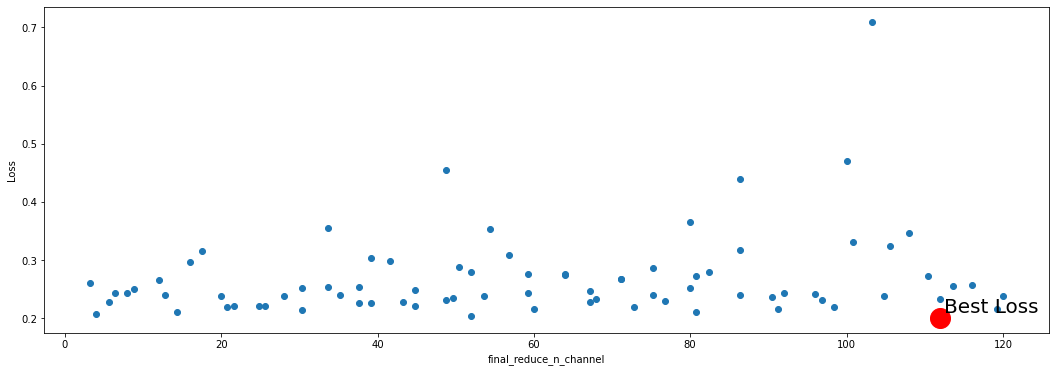

In [22]:
n_chns = []
losses = []
for i in range(len(trials.trials)):
  n_chn = trials.trials[i]['misc']['vals']['quniform'] # trials.trials = list of dictionaries representing everything about the search
  if not n_chn:
    n_chn = [-1]

  n_chns.append(n_chn[0])
  losses.append(trials.trials[i]['result']['loss'])


plt.figure(figsize=(18,6))

best_loss_index = np.argmin(losses) # argmin returns indices of minimum value [which position in list!]
best_loss = losses[best_loss_index] # here: take indices of minium values as best loss = minimum loss
best_loss_nch = n_chns[best_loss_index]

plt.plot(best_loss_nch,best_loss,color='r', marker='o', markersize=20)
plt.text(best_loss_nch + 0.5, best_loss + .01, 'Best Loss', fontsize=20,color='k')

plt.scatter(n_chns, losses)
plt.xlabel('final_reduce_n_channel')
plt.ylabel('Loss')

plt.show()

In [23]:
best_model_weights_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_weights']
best_model_weights = pickle.loads(best_model_weights_dmp)

best_model_json_dmp = trials.trial_attachments(trials.trials[best_loss_index])['model_json']
best_model_json = pickle.loads(best_model_json_dmp)

best_model = keras.models.model_from_json(best_model_json)
best_model.set_weights(best_model_weights)


In [24]:
best_model.save("models/3_best_model")

INFO:tensorflow:Assets written to: models/3_best_model\assets


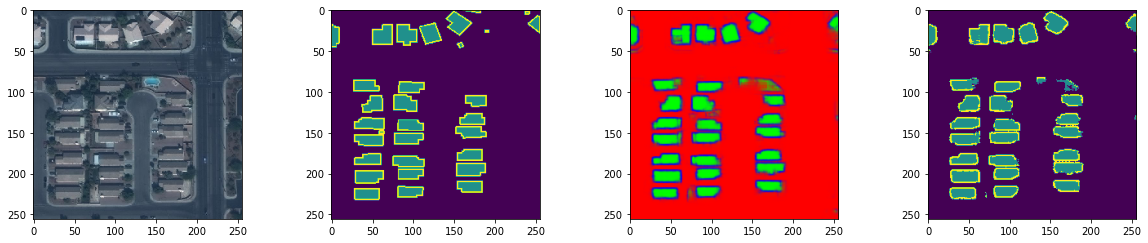

In [25]:
_ = validate_image(img_val,mask_val,best_model)
# 1: img  2: mask  3: mask_prediction hyperopt model  4: mask_pred_rend hyperopt model

Improved output for comparison

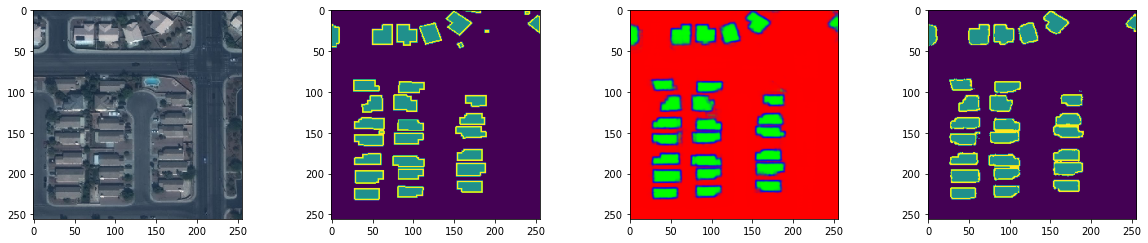

In [26]:
_ = validate_image(img_val,mask_val,model_improved)

# Test F1 all classes

precision = True Positive / (True Positive + False Positive) OR True Positive / Total predicted Positive

recall = True Positive / (True Positive + False Negative) OR  True Positive / Total actual Positive

f1 = 2x (precision x recall)/ (precision + recall)

In [27]:
test_img,test_mask = next(test_gen)
test_mask = np.squeeze(test_mask)

test_mask_pred = best_model.predict(test_img)
test_mask_pred_rend = np.argmax(test_mask_pred,axis=-1)

cfm = multilabel_confusion_matrix(test_mask.flatten(),test_mask_pred_rend.flatten())

In [28]:
for i in range(3):
  prec = cfm[i,1,1]/(cfm[i,1,1]+cfm[i,0,1]) 
  recall= cfm[i,1,1]/(cfm[i,1,1]+cfm[i,1,0])
  f1  = 2*prec*recall/(prec+recall)
  print('F1 score for class {} :'.format(i),f1) 
# I do not understand which class is what!

F1 score for class 0 : 0.9621296864557832
F1 score for class 1 : 0.8487271757738716
F1 score for class 2 : 0.5276223301942384


# BASELINE MODEL

#####  - also execute model without the final reduce to be able to compare the influence of the last layer reduce - 

In [29]:
model_baseline = unetModel(final_reduce=False, final_reduce_n_channel=30) 
model_baseline.compile(optimizer='adam',metrics = ['sparse_categorical_accuracy'],loss= 'sparse_categorical_crossentropy')

In [30]:
# look at model 
#model_baseline.summary()

In [31]:
%%time
logdir = 'log_dir/baseline/12' # ADAPT every time running the model!!

os.makedirs(logdir,exist_ok=True)


tensorboard = keras.callbacks.TensorBoard(log_dir=logdir,
                                        histogram_freq=1,
                                        update_freq = 'epoch',                                     
                                        write_graph=True
                                         )
# early stopping to find the "perfect" amount of epoches to avoid over- and underfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               min_delta=0.001,  #minimum amount of change to count as an improvement)
                                               patience=5, # number of epochs with no improvement after which training will be stopped
                                               restore_best_weights=True
                                              )
                                    

history_model_baseline = model_baseline.fit(train_gen, 
                              steps_per_epoch=25, 
                              epochs=200,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=19,
                              callbacks=[tensorboard, early_stopping])

Epoch 1/200
25/25 [==============================] - 189s 8s/step - loss: 0.4894 - sparse_categorical_accuracy: 0.8158 - val_loss: 1.1835 - val_sparse_categorical_accuracy: 0.6379
Epoch 2/200
25/25 [==============================] - 5s 214ms/step - loss: 0.3771 - sparse_categorical_accuracy: 0.8583 - val_loss: 2.4770 - val_sparse_categorical_accuracy: 0.2049
Epoch 3/200
25/25 [==============================] - 5s 214ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.8737 - val_loss: 1.2170 - val_sparse_categorical_accuracy: 0.5241
Epoch 4/200
25/25 [==============================] - 5s 213ms/step - loss: 0.3078 - sparse_categorical_accuracy: 0.8890 - val_loss: 0.9877 - val_sparse_categorical_accuracy: 0.6181
Epoch 5/200
25/25 [==============================] - 5s 212ms/step - loss: 0.2899 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.4543 - val_sparse_categorical_accuracy: 0.8352
Epoch 6/200
25/25 [==============================] - 5s 213ms/step - loss: 0.2916 - sparse_categ

In [32]:
#saving the model for later

model_baseline.save("models/12_model_baseline")
#model_baseline = keras.models.load_model("5_model_improved")
#model_baseline.summary()

INFO:tensorflow:Assets written to: models/12_model_baseline\assets


## Baseline Validation

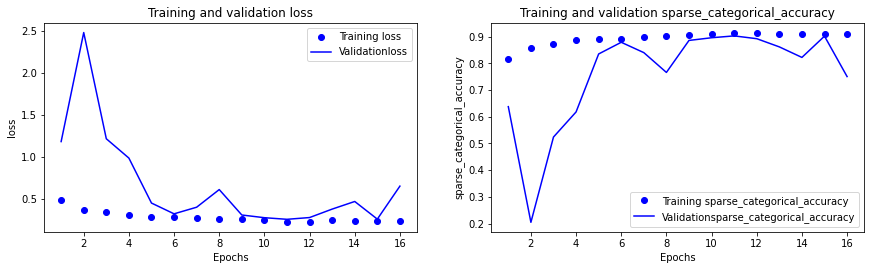

In [33]:
plot_history(history_model_baseline.history)

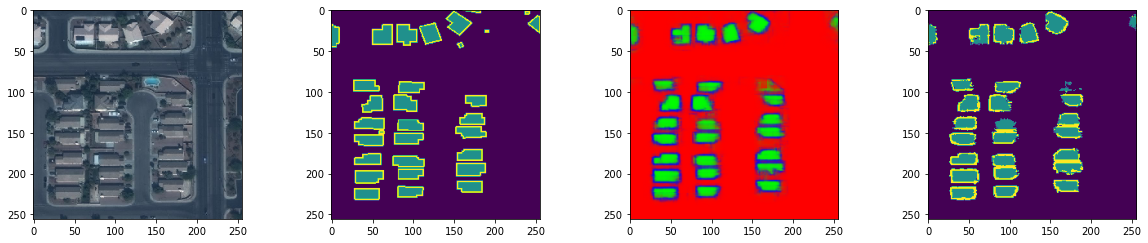

In [34]:
_ = validate_image(img_val,mask_val,model_baseline)
# 1: img  2: mask  3: mask_prediction model_baseline  4: mask_pred_rend model_baseline 

## Baseline Testing / Evaluation

In [ ]:
# Model evaluation
# Test model against the test dataset that we set aside earlier

#model_baseline.evaluate(test_gen, verbose=2)

# TensorBoard

In [ ]:
#If you are running notebook in Google colab, Sometimes it is necessaty to run this cell twice to start tensorboard extension

#%tensorboard --logdir log_dir/base_line/0

In [ ]:
#####stop tensorboard

#!kill `ps aux|egrep tensorboard|grep -v grep|awk '{print $2}'`; echo "Stopping tensorboard res $?"

# Prediction / Application of Model

In [35]:
#make predictions on test_gen
test_image_gen   = make_gen4unet(df_test, batch_size=1)
print(test_image_gen)
img_test, mask_test = next(test_image_gen)
print(img_test.shape)

Found 578 validated image filenames.
Found 578 validated image filenames.
<generator object make_gen4unet.<locals>._gen at 0x000001690A1556C8>
(1, 256, 256, 3)


In [36]:
# Generate output predictions for the input samples
mask_predicted = model_improved.predict(test_image_gen, verbose = 1)

  12290/Unknown - 85s 7ms/step

ResourceExhaustedError:  OOM when allocating tensor with shape[1,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/concatenate_2/concat (defined at <ipython-input-36-4151ab4862fb>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_693052]

Function call stack:
predict_function


In [ ]:
# define function to display the results
def predict_buildings(img, mask_pred):
    i=0
    img=img[i].astype(int)
    mask_pred=np.squeeze(mask_pred[i])
    mask_pred_rend=np.argmax(mask_pred, axis=-1)
    plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
    plt.subplot(131) # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask_pred)
    plt.subplot(133)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

In [ ]:
mask_predicted, mask_predicted_rend= predict_buildings(test_imgage_gen, mask_predicted)